In [9]:
# импорт всех необходимых библиотек
import numpy as np
import pandas as pd
import cv2
import random
from copy import deepcopy
from matplotlib import pyplot as plt 
import seaborn as sns
import gymnasium as gym
import ale_py
from collections import deque
import torch
from torch import nn
import plotly.express as px
from torch.utils.tensorboard import SummaryWriter

### Загрузка среды

Начальное состояние: (210, 160, 3)
Информация о среде: {'lives': 5, 'episode_frame_number': 0, 'frame_number': 0}


A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


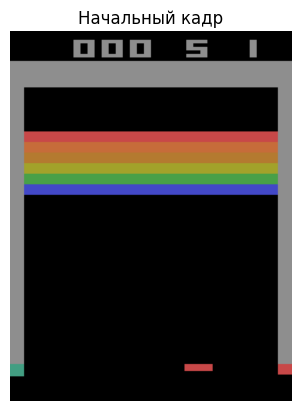

Действие: 0, Награда: 0.0, Завершено: False


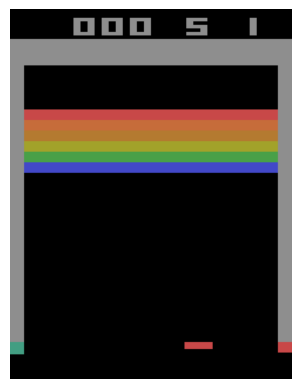

Действие: 1, Награда: 0.0, Завершено: False


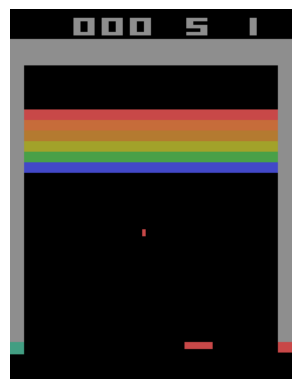

Действие: 2, Награда: 0.0, Завершено: False


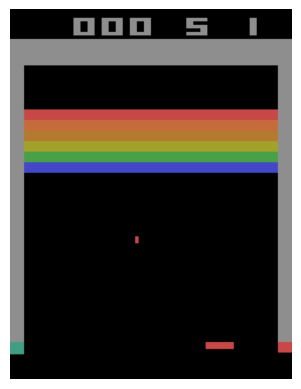

Действие: 0, Награда: 0.0, Завершено: False


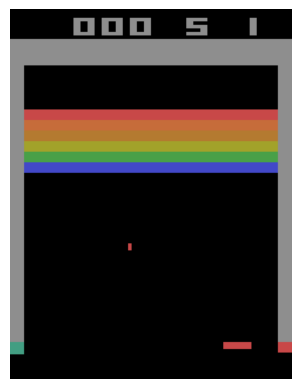

Действие: 3, Награда: 0.0, Завершено: False


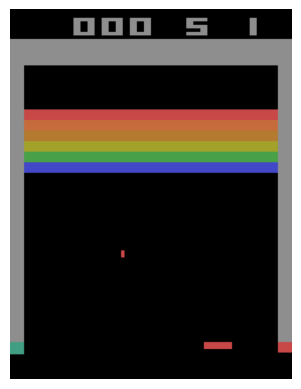

In [3]:
# Загрузка среды
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.25, render_mode='rgb_array')
state, info = env.reset()

# Проверка начального состояния
print("Начальное состояние:", state.shape)
print("Информация о среде:", info)

# Визуализация начального кадра
plt.imshow(env.render())
plt.title("Начальный кадр")
plt.axis("off")
plt.show()

# Тестирование выполнения нескольких действий
for _ in range(5):
    action = env.action_space.sample()  # Случайное действие
    state, reward, terminated, truncated, info = env.step(action)
    print(f"Действие: {action}, Награда: {reward}, Завершено: {terminated or truncated}")
    plt.imshow(env.render())
    plt.axis("off")
    plt.show()

env.close()


### Класс DQN
Этот класс описывает нейронную сеть для аппроксимации Q-функции, которая используется для вычисления Q-значений для всех действий.

In [4]:
class DQN(nn.Module):
    def __init__(self, num_action_space):
        super().__init__()
        self.m = num_action_space

        # Сверточные слои (CNN) для выделения признаков из изображений
        self.features = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),  # Слой с большим рецептивным полем
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # Увеличение глубины фильтров
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # Детализация мелких признаков
            nn.ReLU()
        )
        
        # Полносвязные слои для Q-функции
        self.fcnn = nn.Sequential(
            nn.Flatten(),  # Преобразование тензора в вектор
            nn.Linear(3136, 512),  # Скрытый слой
            nn.ReLU(),
            nn.Linear(512, self.m),  # Выходной слой для Q-значений каждого действия
        )
        
        # Функция потерь и оптимизатор
        self.loss_fn = nn.HuberLoss()  # HuberLoss для стабильности
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4, amsgrad=True)  # AdamW для лучшей регуляризации

    def forward(self, X):
        # Прямое распространение: последовательное применение CNN и полносвязных слоев
        return self.fcnn(self.features(X))


### Класс DQNAgent
Этот класс реализует DQN-агента. Он включает обработку состояний, стратегию выбора действий, буфер воспроизведения и процесс обучения.

In [5]:
class DQNAgent(nn.Module):
    def __init__(
        self,
        num_action_space,
        batch_size,
        memory_size=80_000,
        gamma=0.99,
        update_rate=10_000,
        epsilon=1,
        min_epsilon=0.1,
        max_epsilon=1,
        epsilon_greedy_rate=1_000_000
    ):
        super().__init__()
        self.m = num_action_space  # Размер пространства действий
        self.e = epsilon  # Начальное значение ε
        self.e_min = min_epsilon  # Минимальное значение ε
        self.e_max = max_epsilon  # Максимальное значение ε
        self.e_rate = (self.e_max - self.e_min) / epsilon_greedy_rate  # Скорость уменьшения ε
        self.b = batch_size  # Размер мини-батча
        self.Q = DQN(self.m).to(device)  # Основная Q-сеть
        self.T = deepcopy(self.Q)  # Целевая Q-сеть
        self.g = gamma  # Коэффициент дисконтирования
        self.r = update_rate  # Частота обновления целевой сети
        
        # Деактивация градиентов для целевой сети
        for p in self.T.parameters():
            p.requires_grad = False
        
        # Инициализация буфера воспроизведения
        self.mc = memory_size
        self.memory = deque(maxlen=self.mc)

        self.update_target_network()

    def preprocess(self, state):
        # Преобразование изображения в градации серого, изменение размера и нормализация
        state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)[32:,8:152]
        state = cv2.resize(src=state, dsize=(84, 84)) / 255.
        return torch.from_numpy(state.astype(np.float32)).to(device)

    def update_target_network(self):
        # Синхронизация параметров основной и целевой сети
        self.T.load_state_dict(self.Q.state_dict())
        
    def act(self, state, ep=None):
        if np.random.uniform(0, 1) < (ep or self.e):
            action = np.random.randint(self.m)  # Случайное действие
        else:
            action = self.Q(state.unsqueeze(0))[0].argmax().item()  # Жадный выбор
        
        if not ep:
            self.e -= self.e_rate
            self.e = max(self.e_min, self.e)  # Обновление ε
        return action
    
    def cache(self, exp):
        # Добавление опыта в буфер воспроизведения
        s, a, r, s_, d = exp
        a = torch.tensor(a).to(device)
        r = torch.sign(torch.tensor(r)).to(device)  # Нормализация награды
        d = torch.tensor(d).to(device)
        self.memory.append((s, a, r, s_, d))
        
    def memory_size(self):
        return len(self.memory)
    
    def sample_memory(self):
        return random.sample(self.memory, self.b)
    
    def update_epsilon(e, e_min, e_max, epsilon_greedy_rate):
        self.e, self.e_min, self.e_max = e, e_min, e_max
        self.e_rate = (self.e_max - self.e_min) / epsilon_greedy_rate    
        
    def learn(self):
        if self.memory_size() < self.b:
            return
        
        # Выбор случайного мини-батча из памяти
        exps = self.sample_memory()
        s, a, r, s_, d = map(torch.stack, zip(*exps))
        
        # Предсказания Q-сети
        pred_q = self.Q(s)[np.arange(self.b), a]
        
        # Целевые значения Q с использованием целевой сети
        target_q = r + (1 - d.float()) * self.g * self.T(s_).max(axis=1).values
        
        # Обучение
        self.Q.optimizer.zero_grad()
        loss = self.Q.loss_fn(pred_q, target_q)
        loss.backward()
        self.Q.optimizer.step()
        
    def save(self, steps):
        torch.save(
            dict(model=self.Q.state_dict(), exploration_rate=self.e),
            f'DQNAgent-{steps}.chkpt',
        )
        
    def load(self, path):
        model_state_dict, epsilon = torch.load(path).values()
        self.Q.load_state_dict(model_state_dict)
        self.T.load_state_dict(model_state_dict)
        self.e = epsilon        


### Класс DDQNAgent
Наследуется от DQNAgent, но использует Double DQN для обучения.

In [6]:
class DDQNAgent(DQNAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def learn(self):
        if self.memory_size() < self.b: return
        
        exps = self.sample_memory()
        s, a, r, s_, d = map(torch.stack, zip(*exps))
        
        # Double DQN: выбор действия основной сетью, вычисление Q целевой
        pred_q = self.Q(s)[np.arange(self.b), a]
        target_q = r + (1 - d.float()) * self.g * self.T(s_)[
            np.arange(self.b),
            self.Q(s_).argmax(axis=1)
        ]
        
        # Обучение
        self.Q.optimizer.zero_grad()
        loss = self.Q.loss_fn(pred_q, target_q)
        loss.backward()
        self.Q.optimizer.step()
        
    def save(self, steps):
        torch.save(
            dict(
                model=self.Q.state_dict(),  # Сохраняем веса модели
                exploration_rate=self.e    # Сохраняем текущее значение epsilon
            ),
            f'DDQNAgent-{steps}.chkpt',
        )


### Инициализация агента

In [36]:
# Atari breakout
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.25, render_mode='rgb_array')

env.reset()
env.metadata['render_fps'] = 24
writer = SummaryWriter('runs/ddqn-nature2')

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


batch_size = 32

## Agent 
agent = DDQNAgent(
    env.action_space.n,
    batch_size,
)

# agent.load("DDQNAgent-final.chkpt")
agent.e = 1  #первоначальное значение эпсилона


<All keys matched successfully>

### Обучение агента

In [7]:
def train():
    global steps, return_arr, epochs, num_timesteps, ep, episode, results_df

    for epoch in range(epochs):
        state, info = env.reset()
        old_lives = info['lives']
        
        # Ударить мяч, чтобы он стал видимым
        state = env.step(1)[0]
        state = agent.preprocess(state)
        state = torch.stack([state, state, state, state])
        
        print('===================================')
        print(f'Epoch: {epoch}')
        ep_steps = 0
        episode_return = 0

        for step in range(num_timesteps):
            action = agent.act(state)
            next_state, reward, done, truncated, info = env.step(action)

            next_state = agent.preprocess(next_state)
            next_state = torch.stack([*state[1:], next_state])
            
            agent.cache((state, action, reward, next_state, done or truncated))
            state = next_state

            episode_return += reward
            ep_steps += 1
            agent.learn()
            steps += 1

            # Ударить мяч, если потеряна жизнь
            if old_lives > info['lives']:
                state = env.step(1)[0]
                state = agent.preprocess(state)
                state = torch.stack([state, state, state, state])
                old_lives = info['lives']

            if done or truncated:
                print('-----------------------')
                print(f'Episode: {episode}')
                print(f'Epsilon: {agent.e}')
                print(f'Step: {steps}, Return: {episode_return}\n')
                writer.add_scalar('Return', episode_return, steps)
                writer.add_scalar('Steps per episode', ep_steps, steps)
                writer.add_scalar('Epsilon', agent.e, steps)
                writer.add_scalar('Total episodes', episode, steps)

                # Логируем результаты в DataFrame
                new_row = pd.DataFrame([{
                    "Step": steps,
                    "Episode": episode,
                    "Return": episode_return,
                    "Epsilon": agent.e
                }])
                results_df = pd.concat([results_df, new_row], ignore_index=True)

                # Сброс состояния для нового эпизода
                state, info = env.reset()
                state = env.step(1)[0]
                state = agent.preprocess(state)
                state = torch.stack([state, state, state, state])

                return_arr.append(episode_return)
                episode_return = 0
                ep_steps = 0
                episode += 1

            if steps % agent.r == 0:
                agent.update_target_network()
                print(f'Step: {steps}, Return: {episode_return}')
        
        agent.save(f'final-{steps}')
    
    return {
        "Model": "DDQN",
        "Latest average reward": np.mean(return_arr[-num_timesteps:]),
        "Steps": steps,
        "Episodes": episode
    }


In [8]:
# Инициализация глобальных переменных
results_df = pd.DataFrame(columns=["Step", "Episode", "Return", "Epsilon"])
return_arr = []
num_timesteps = 1_000_000
epochs = 10
steps = 0
episode = 1

# Запуск обучения
train()

Epoch: 0
-----------------------
Episode: 1
Epsilon: 0.999849700000005
Step: 167, Return: 1.0



/var/folders/fd/5vxl77xx7632b4n8c0lcs24h0000gn/T/ipykernel_99330/4259540467.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


-----------------------
Episode: 2
Epsilon: 0.999727300000009
Step: 303, Return: 0.0

-----------------------
Episode: 3
Epsilon: 0.9995824000000137
Step: 464, Return: 1.0

-----------------------
Episode: 4
Epsilon: 0.9993781000000205
Step: 691, Return: 2.0

-----------------------
Episode: 5
Epsilon: 0.999149500000028
Step: 945, Return: 3.0

-----------------------
Episode: 6
Epsilon: 0.9990082000000327
Step: 1102, Return: 1.0

-----------------------
Episode: 7
Epsilon: 0.9988183000000389
Step: 1313, Return: 2.0

-----------------------
Episode: 8
Epsilon: 0.9986734000000437
Step: 1474, Return: 1.0

-----------------------
Episode: 9
Epsilon: 0.9985519000000477
Step: 1609, Return: 0.0

-----------------------
Episode: 10
Epsilon: 0.9984061000000525
Step: 1771, Return: 1.0

-----------------------
Episode: 11
Epsilon: 0.9982225000000585
Step: 1975, Return: 2.0

-----------------------
Episode: 12
Epsilon: 0.9981091000000623
Step: 2101, Return: 0.0

-----------------------
Episode: 13

KeyboardInterrupt: 

In [6]:
# Сохранение агента
torch.save(
    dict(
        model=agent.Q.state_dict(),
        exploration_rate=agent.e  # Добавляем epsilon
    ),
    f'DDQNAgent-final.chkpt',
)

# Сохранение в CSV после завершения обучения
results_df.to_csv("training_results.csv", index=False)

NameError: name 'agent' is not defined

### Обучение случайного агента

In [34]:
def train_random_agent():
    global steps, return_arr, epochs, num_timesteps, ep, episode, random_results_df

    for epoch in range(epochs):
        state, info = env.reset()
        old_lives = info['lives']
        
        # Ударить мяч, чтобы он стал видимым
        state = env.step(1)[0]
        state = agent.preprocess(state)
        state = torch.stack([state, state, state, state])
        
        print('===================================')
        print(f'Epoch (Random): {epoch}')
        ep_steps = 0
        episode_return = 0

        for step in range(num_timesteps):
            # Выбор случайного действия
            action = env.action_space.sample()
            
            next_state, reward, done, truncated, info = env.step(action)

            next_state = agent.preprocess(next_state)
            next_state = torch.stack([*state[1:], next_state])
            
            # Обновляем состояние
            state = next_state
            episode_return += reward
            ep_steps += 1
            steps += 1

            # Ударить мяч, если потеряна жизнь
            if old_lives > info['lives']:
                state = env.step(1)[0]
                state = agent.preprocess(state)
                state = torch.stack([state, state, state, state])
                old_lives = info['lives']

            if done or truncated:
                print('-----------------------')
                print(f'Episode (Random): {episode}')
                print(f'Step: {steps}, Return: {episode_return}\n')

                # Логируем результаты в DataFrame
                new_row = pd.DataFrame([{
                    "Step": steps,
                    "Episode": episode,
                    "Return": episode_return,
                    "Epsilon": "Random"
                }])
                random_results_df = pd.concat([random_results_df, new_row], ignore_index=True)

                # Сброс состояния для нового эпизода
                state, info = env.reset()
                state = env.step(1)[0]
                state = agent.preprocess(state)
                state = torch.stack([state, state, state, state])

                return_arr.append(episode_return)
                episode_return = 0
                ep_steps = 0
                episode += 1
        
        print(f'Epoch {epoch} completed for Random Agent')
    
    return {
        "Model": "Random",
        "Latest average reward": np.mean(return_arr[-num_timesteps:]),
        "Steps": steps,
        "Episodes": episode
    }


In [38]:
# Atari breakout
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.25, render_mode='rgb_array')

env.reset()
env.metadata['render_fps'] = 24
writer = SummaryWriter('runs/ddqn-nature2')

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


batch_size = 32

## Agent 
agent = DDQNAgent(
    env.action_space.n,
    batch_size,
)

agent.e = 1  #первоначальное значение эпсилона


# Инициализация глобальных переменных
random_results_df = pd.DataFrame(columns=["Step", "Episode", "Return", "Epsilon"])
return_arr = []
num_timesteps = 1_000_000
epochs = 10
steps = 0
episode = 1

# Запуск обучения
train_random_agent()

Epoch (Random): 0
-----------------------
Episode (Random): 1
Step: 212, Return: 2.0



/var/folders/fd/5vxl77xx7632b4n8c0lcs24h0000gn/T/ipykernel_17043/1154447108.py:52: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



-----------------------
Episode (Random): 2
Step: 341, Return: 0.0

-----------------------
Episode (Random): 3
Step: 545, Return: 2.0

-----------------------
Episode (Random): 4
Step: 768, Return: 2.0

-----------------------
Episode (Random): 5
Step: 985, Return: 2.0

-----------------------
Episode (Random): 6
Step: 1187, Return: 2.0

-----------------------
Episode (Random): 7
Step: 1382, Return: 1.0

-----------------------
Episode (Random): 8
Step: 1537, Return: 1.0

-----------------------
Episode (Random): 9
Step: 1665, Return: 0.0

-----------------------
Episode (Random): 10
Step: 1810, Return: 0.0

-----------------------
Episode (Random): 11
Step: 1952, Return: 0.0

-----------------------
Episode (Random): 12
Step: 2091, Return: 0.0

-----------------------
Episode (Random): 13
Step: 2247, Return: 1.0

-----------------------
Episode (Random): 14
Step: 2369, Return: 0.0

-----------------------
Episode (Random): 15
Step: 2553, Return: 1.0

-----------------------
Episode 

-----------------------
Episode (Random): 120
Step: 21670, Return: 1.0

-----------------------
Episode (Random): 121
Step: 21824, Return: 1.0

-----------------------
Episode (Random): 122
Step: 22044, Return: 2.0

-----------------------
Episode (Random): 123
Step: 22211, Return: 1.0

-----------------------
Episode (Random): 124
Step: 22396, Return: 1.0



KeyboardInterrupt: 

In [40]:
random_results_df.to_csv('training_random_results.csv')

## Анализ результатов

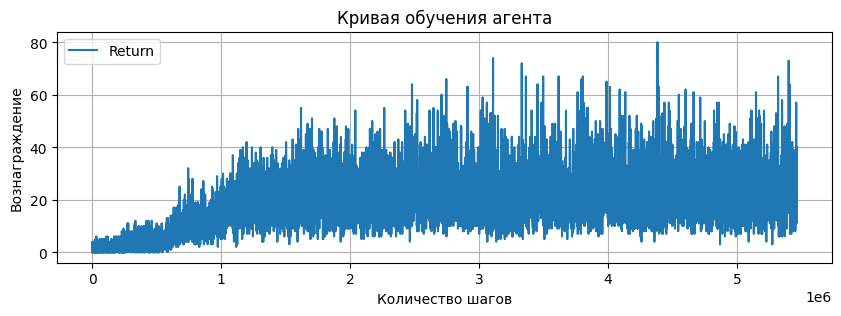

In [45]:
# Загрузка данных из сохраненного CSV
results_df = pd.read_csv("training_results.csv")

# График зависимости награды от количества шагов
plt.figure(figsize=(10, 3))
sns.lineplot(data=results_df, x="Step", y="Return", label="Return")
plt.title("Кривая обучения агента")
plt.xlabel("Количество шагов")
plt.ylabel("Вознаграждение")
plt.legend()
plt.grid()
plt.show()


In [46]:
# Рассчет скользящего среднего вознаграждения
window_size = 100
results_df["MovingAverage"] = results_df["Return"].rolling(window=window_size).mean()

# Основные метрики
final_avg_return = results_df["Return"].iloc[-window_size:].mean()
std_return = results_df["Return"].std()

print(f"Среднее вознаграждение за последние {window_size} эпизодов: {final_avg_return}")
print(f"Стандартное отклонение вознаграждения: {std_return}")


Среднее вознаграждение за последние 100 эпизодов: 23.37
Стандартное отклонение вознаграждения: 11.913723864480135


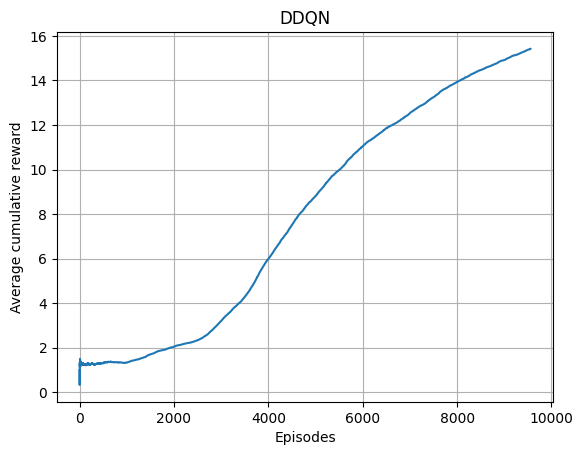

In [47]:
plt.title('DDQN')
plt.grid()
plt.ylabel('Average cumulative reward')
plt.xlabel('Episodes')
plt.plot(np.cumsum(results_df['Return']) / np.arange(1, len(results_df['Return'])+1))

Теперь тоже самое для случайного обучения.

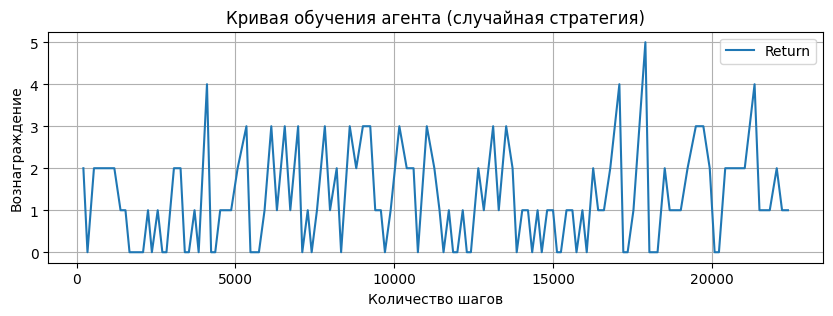

In [41]:
# Загрузка данных из сохраненного CSV
random_results_df = pd.read_csv("training_random_results.csv")

# График зависимости награды от количества шагов
plt.figure(figsize=(10, 3))
sns.lineplot(data=random_results_df, x="Step", y="Return", label="Return")
plt.title("Кривая обучения агента (случайная стратегия)")
plt.xlabel("Количество шагов")
plt.ylabel("Вознаграждение")
plt.legend()
plt.grid()
plt.show()


In [43]:
# Рассчет скользящего среднего вознаграждения
window_size = 100
random_results_df["MovingAverage"] = random_results_df["Return"].rolling(window=window_size).mean()

# Основные метрики
final_avg_return = random_results_df["Return"].iloc[-window_size:].mean()
std_return = random_results_df["Return"].std()

print(f"Среднее вознаграждение за последние {window_size} эпизодов: {final_avg_return}")
print(f"Стандартное отклонение вознаграждения: {std_return}")


Среднее вознаграждение за последние 100 эпизодов: 1.27
Стандартное отклонение вознаграждения: 1.135346324787968


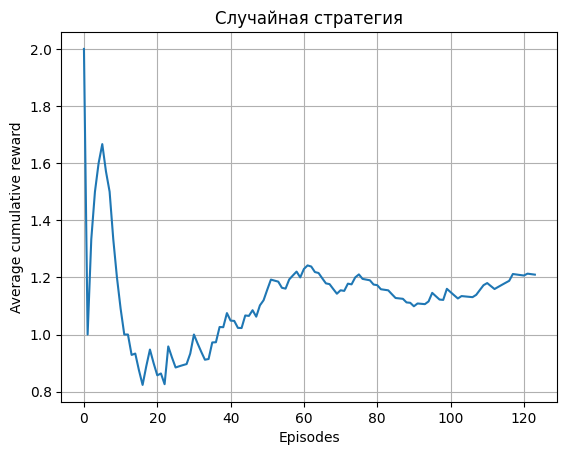

In [42]:
plt.title('Случайная стратегия')
plt.grid()
plt.ylabel('Average cumulative reward')
plt.xlabel('Episodes')
plt.plot(np.cumsum(random_results_df['Return']) / np.arange(1, len(random_results_df['Return'])+1))

### Тестирование агента

In [10]:
# Atari breakout
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.25, render_mode='rgb_array')

env.reset()
env.metadata['render_fps'] = 24
writer = SummaryWriter('runs/ddqn-nature2')

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


batch_size = 32

## Agent 
agent = DDQNAgent(
    env.action_space.n,
    batch_size,
)

# Загружаем checkpoint на CPU
checkpoint = torch.load("DDQNAgent-final.chkpt", map_location=torch.device('cpu'))
# Восстанавливаем exploration_rate (epsilon)
agent.e = checkpoint['exploration_rate']
# Загружаем веса модели в Q-сеть агента
agent.Q.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [11]:
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0, render_mode='human')

### Play and display in pygame window.

episodes = 10
for e in range(episodes):
    Return = 0
    s, _ = env.reset()
    s = env.step(1)
    s = s[0]
    s = agent.preprocess(s)
    s = torch.stack([s, s, s, s])
    steps = 10_000
    for i in range(steps):
        a = agent.act(s)
        (s_, r, d, t, _) = env.step(a)
        s_ = agent.preprocess(s_)
        s_ = torch.stack([*s[1:], s_])
        s = s_
        Return += r
        
        if d or t:
            print('done d')
            break
            
    if (e + 1 ) % 10 == 0:
        print(f"Episode: {e+1}, Return: {Return}")
print(Return)

done d
done d


KeyboardInterrupt: 